In this section we illustrate the concepts discussed in this chapter by
building a classifier to discriminate between healthy tissues and tumors
using a micro RNA (miRNA) expression profile. We replicate a study by Chan et al. (2013) who analyzed the expression profile of breast cancer
tumors tissues of 32 patients and healthy breast tissue of 22 control
patients. The expression of 284 miRNAs is given. For details we refer to
the original study from which the data is obtained.

What follows can be seen as a brief tutorial on how to build, analyze
and validate machine learning models in the Python programming language.
We use the popular data science packages `pandas` (to load data sets into Python)
and `scikit-learn` which implements the most commonly-used machine
learning models, in addition to tools for data preprocessing and model
selection. The analysis is performed in a Jupyter notebook, which allows
for interactive computing and is a useful tool working with data sets.
The notebook with these methods can be downloaded from our Github
account.

We load some useful libraries before we load the data set. Every
observation has an identifier, starting with a 'c' if it originates from
cancerous tissue and 's' if it is obtained from healthy tissue.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd

Pandas can directly read comma separated values (CSV) files.

In [2]:
expression = pd.read_csv('GSE41922_non-normalized.txt', sep='\t',
                         skiprows=5, index_col=0).T

expression.head()  # show first five rows and columns

ID_REF,SNORD38B,SNORD38B,U6,U6,UniSp6,UniSp6 CP,hsa-let-7a,hsa-let-7a*,hsa-let-7b,hsa-let-7b*,...,hsa-miR-92b,hsa-miR-93,hsa-miR-93*,hsa-miR-940,hsa-miR-942,hsa-miR-95,hsa-miR-96,hsa-miR-98,hsa-miR-99a,hsa-miR-99b
c1,33.011521,33.780086,33.339544,34.588958,17.555213,18.890340,29.029999,32.654121,26.951386,31.404714,...,33.568794,25.805030,32.445736,35.080479,33.965286,34.094918,33.767049,34.904610,30.613970,30.780152
c2,NaN,32.920894,34.898294,NaN,25.380582,23.955199,29.343180,33.335356,26.772231,32.246711,...,35.338467,25.770784,32.854346,35.265154,34.909096,35.282212,34.482426,34.602730,31.220101,31.290000
c3,NaN,35.932016,NaN,36.157710,16.164793,16.167580,31.472186,36.554881,29.155717,32.789428,...,NaN,28.334208,35.072266,34.691540,36.930316,NaN,36.383084,NaN,32.768986,32.547749
c4,35.242001,NaN,NaN,NaN,16.159548,16.073088,32.005424,34.744300,29.103268,32.593478,...,35.680966,27.504319,34.949666,34.613847,NaN,NaN,36.172726,NaN,31.097417,32.917477
c5,33.232949,35.095958,32.428277,33.453761,16.016061,16.032326,30.103360,33.553958,27.065524,32.056518,...,34.713978,26.280886,33.279762,33.270474,36.013236,34.641400,NaN,35.996364,28.909959,31.201527


In [3]:
miRNAs = expression.columns
patients = expression.index

It is usually a good idea to first make a heat map of the data set.

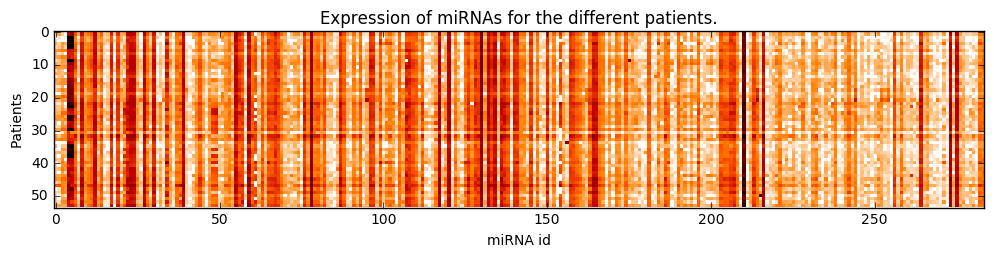

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('miRNA id')
ax.set_ylabel('Patients')
ax.set_title('Expression of miRNAs for the different patients.')
ax.imshow(expression, cmap='gist_heat',
          interpolation='nearest')

In this heat map, with lighter colors indicating a higher expression, we
see a large difference between the individual genes (columns). From this
plot, and by directly looking at the data, we notice that there are some
missing values. As most machine learning methods cannot directly cope
with missing values, we shall need to impute them. An easy way to fill
the missing values is to replace them with the corresponding column
average. It is usually beneficial to standardize the data such that
every column has an average of zero and unit variance. Both missing
value imputation and feature standardization can be combined in a preprocessing
pipeline in `Scikit-learn`. We will also construct a binary vector
indicating whether the tissue is healthy or not

In [5]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline

In [6]:
imputer_normalizer = Pipeline(steps=[
    # impute missing values with the column mean
    ('imputer', Imputer()),
    # standardize the data such that
    # every row has zero mean and unit variance
    ('standarized', StandardScaler())  
])

X = imputer_normalizer.fit_transform(expression)

In [7]:
y = np.array([id[0]=='s' for id in expression.index])

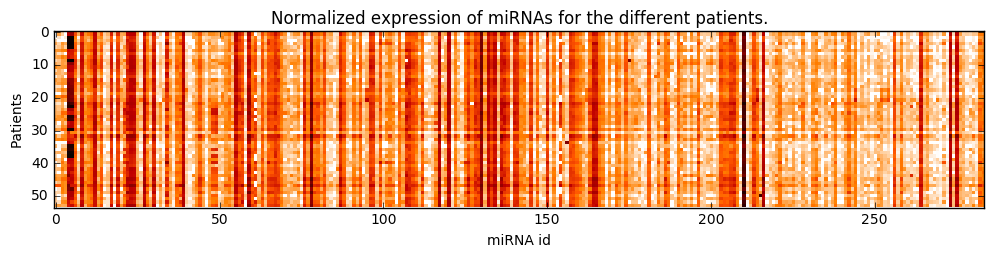

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('miRNA id')
ax.set_ylabel('Patients')
ax.set_title('Normalized expression of miRNAs for the different patients.')
ax.imshow(expression, cmap='gist_heat',
          interpolation='nearest')

Before building a model, we will project the data into two dimensions
using principal component analysis. Note that first an instance of a
model is created with the given parameters and that subsequently the
model is fitted using the `fit()` handle. The data is then
represented in a scatter plot.

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(n_components=2)  # project in two dimensions
X_reduced = pca.fit_transform(X)

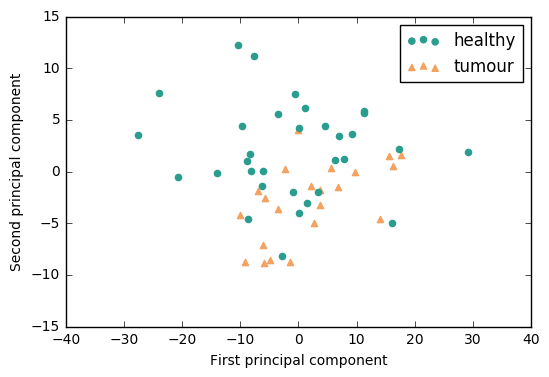

In [12]:
fig, ax = plt.subplots()  # make a new plot

for i, id in enumerate(expression.index):
    if y[i]:  # healthy
        ax.scatter(X_reduced[i,0], X_reduced[i,1], color='#2a9d8f')
    else:  # tumor
        ax.scatter(X_reduced[i,0], X_reduced[i,1], color='#f4a261',
                                   marker='^')
    
ax.scatter([], [], color='#2a9d8f', label='healthy')
ax.scatter([], [], color='#f4a261', label='tumour', marker='^')
ax.legend(loc=0)
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')

We observe that even using an unsupervised projection in two dimensions the healthy and cancerous tissues do not completely overlap. It seems promissing that a supervised classifier might be able to separate the two classes.

We will build classifiers using naive Bayes (NB), linear discriminant analysis (LDA), logistic regression with $L_1$ and $L_2$ regularization, log support vector classifiers (SVC) with a linear, polynomial and radial basis kernel, a classification and regression tree (CART) and a random forest (RF). For models with hyper parameters we use 4-fold stratified inner cross-validation to find the best model. To assess the performance of the tuned model, we perform 4-fold stratified outer cross-validation. We use accuracy and area under the ROC curve (AUC) as performance metrics. We also use cross-validation to compute the ROC curves.

In [13]:
# machine learning models
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# functions for model selection
from sklearn.model_selection import GridSearchCV,\
                    StratifiedKFold, cross_val_score
# functions for computing the performance of the classifiers
from sklearn.metrics import accuracy_score, roc_auc_score,\
                            make_scorer, auc, roc_curve

In [14]:
scorer = make_scorer(accuracy_score)

# make instances of every model
lda = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')
nb = GaussianNB()
# more complex models have hyperparameters
# `GridSearchCV` uses cross-validation to find
# the best combination of hyper parameters
# by setting `n_jobs=-1` all free computer cores are
# used for the differnt folds, computing in parallel.
lin_svm = GridSearchCV(SVC(kernel='linear', probability=True), cv=4,
            param_grid={'C': np.logspace(-2, 2, 5)}, n_jobs=-1,
            scoring=scorer, refit=True)
poly_svm = GridSearchCV(SVC(kernel='poly', probability=True), cv=4,
            param_grid={'C': np.logspace(-2, 2, 5),
            'degree':[2, 3]}, n_jobs=-1, scoring=scorer)
rbf_svm = GridSearchCV(SVC(kernel='rbf', probability=True), cv=4,
            param_grid={'C': np.logspace(-2, 2, 5)}, n_jobs=-1,
            scoring=scorer)
rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), cv=4,
            param_grid={'n_estimators':[10, 100, 500],
                        'max_features': ['auto', 0.1, 0.25, 0.5]},
            n_jobs=-1, scoring=scorer)
cart = GridSearchCV(DecisionTreeClassifier(), cv=4,
            n_jobs=-1, param_grid={'min_samples_split':[2, 4, 8, 16]},
            scoring=scorer)
lr_l1 = GridSearchCV(LogisticRegression( penalty='l1'), cv=4,
            n_jobs=-1, param_grid={'C': np.logspace(-1, 3, 5)},
            scoring=scorer)
lr_l2 = GridSearchCV(LogisticRegression( penalty='l2', dual=True),
            cv=4, n_jobs=-1, param_grid={'C': np.logspace(-1, 3, 5)},
            scoring=scorer)

In [15]:
# store the models in a dictionary
models = {'LDA' : lda,
            'NB' : nb,
            'logistic (L1)' : lr_l1,
            'logistic (L2)' : lr_l2,
            'SVC (linear)' : lin_svm,
            'SVC (poly)' : poly_svm,
            'SVC (rbf)' : rbf_svm,
            'RF' : rf,
            'CART' : cart,
         }

In [16]:
# store the performances
performances = {}

for model_name, model in models.items():
    perfs = cross_val_score(model, X, y,
                            scoring=scorer,
                            cv=StratifiedKFold(n_splits=4),
                            verbose=False)
    performances[model_name] = {'Acc':np.mean(perfs)}

In [17]:
# we use linear interpolation
# for the ROC curves of the 
# differnt folds

from scipy import interp

tprs = {model_name : [] for model_name in models.keys()}
aucs = {model_name : [] for model_name in models.keys()}

mean_fpr = np.linspace(0, 1, 100)
cv = StratifiedKFold(n_splits=4)

for train, test in cv.split(X, y):
    for model_name, model in models.items():
        # fit and get predictions
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        # compute ROC curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs[model_name].append(interp(mean_fpr, fpr, tpr))
        tprs[model_name][-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs[model_name].append(roc_auc_score(y[test], probas_[:, 1]))

In [18]:
# save aucs
for model_name in models.keys():
    performances[model_name]['AUC'] = np.mean(aucs[model_name])

In [19]:
# show the perofmances in
# a pandas table
pd.DataFrame(performances).T

,AUC,Acc
CART,0.833333,0.798077
LDA,0.966667,0.833791
NB,0.839583,0.721154
RF,0.905729,0.802198
SVC (linear),0.960417,0.869505
SVC (poly),0.780208,0.664835
SVC (rbf),0.926042,0.759615
logistic (L1),0.947917,0.928571
logistic (L2),0.937500,0.890110


Looking at the performance we see that linear models seems to perform best. Logistic regression with $L_1$ regularization scores highest in terms of accuracy, indicating that only a few miRNAs could suffice to classify the tissues. We observe that naive Bayes does not perform well in terms of accuracy. Since it is outcompted by linear discriminant analysis, it is too simple for this data. Clearly, it is beneficial to consider correlations between the expressions. On the other hand, the nonlinear support vector machines also do not perform well, they likely overfit.

For the AUC metric, linear discriminant analysis and the linear support vector machine perform best. The AUC is computed using a probability score, rather than a 'hard' decision. As a result, many classifiers appear to perform better under this more lenient metric.

Rather than a single perfromance metric, it is often more informative to take a look at the ROC curve.

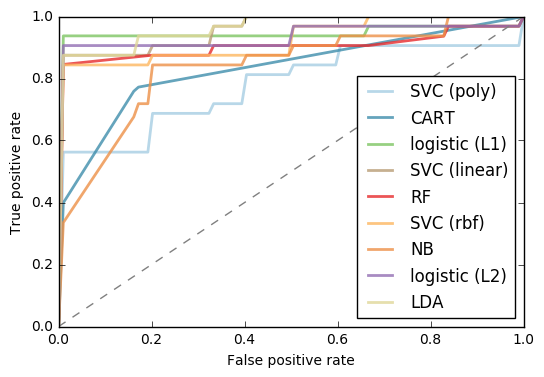

In [20]:
# plot the ROC curves
for i, model_name in enumerate(models.keys()):
    color = plt.get_cmap('Paired')(i/len(models))
    plt.plot(mean_fpr, np.mean(tprs[model_name], 0), color=color,
                         label=model_name, lw=2, alpha=0.8)

plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=0)

Here, we see that many classifiers can attain a true positive rate between 80 and 90% with no false negatives. The $L_1$-regularized logistic regression classifier performs even better! It seems to be possible to detect the diseases with a very high sensitivity. 

Finally, we will explore which genes are important for prediction. One way is to look at the non-zero coefficients in the weight vector of $L_1$ regularized logistic regression. In general, the magnitude of weights of a linear model are **not** a direct indication of variable importance. A variable with a small relative importance but a large variance with likely have a large absolute weight regardless. Since we have standardized all variables however, one can cautiously use the weights as a measure of importance.

As an alternative, we can also retrieve the variable importance computed by the random forest classifier. Since this is a nonlinear classifier, a smaller number of varibles can in principle be used to reproduce the same complexity of a linear model.

In [21]:
# refit the L1 logistic regressor
lr_l1_all_data = LogisticRegression(penalty='l1',
                    C=0.1)  # enforce sparsity
lr_l1_all_data.fit(X, y)
# coefficients of L1 reg logistic regression
coefs_lr_l1 = lr_l1_all_data.coef_[0]
# scale to unit variance
coefs_lr_l1 /= coefs_lr_l1.std()

In [22]:
# refit the random forest model
rf_all_data = RandomForestClassifier(**rf.best_params_)
rf_all_data.fit(X, y)
# get variable importance
importance_rf = rf_all_data.feature_importances_
# scale to unit variance
importance_rf /= importance_rf.std()

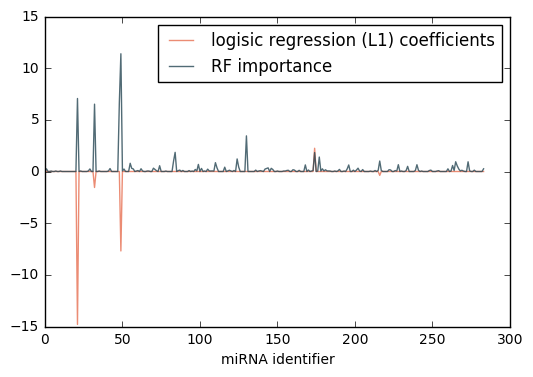

In [23]:
plt.plot(coefs_lr_l1, color='#e76f51', alpha=0.8,
         label='logisic regression (L1) coefficients')
plt.plot(importance_rf, color='#264653', alpha=0.8,
                 label='RF importance')
plt.xlabel('miRNA identifier')
plt.legend(loc=0)

We see a small number of important genes according to the random forest feature importance. We take a closer look at the miRNAs with an scaled importance larger than five.

In [24]:
print(miRNAs[importance_rf > 5])

Index(['hsa-miR-1', 'hsa-miR-10b', 'hsa-miR-133a', 'hsa-miR-133b'], dtype='object', name='ID_REF')


Of these genes, MiR-10b, miR-133a, and miR-133b were also identified as biomarkers for breast cancer according to the original article that published the data. *In vitro* experiments have shown that these are indeed predicitive.